In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import string
# import contractions
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# sklearn
from sklearn.model_selection import StratifiedShuffleSplit

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## EDA
1. Transform label into number
2. View data distribution (imbalance or not)
3. View token length distribution
4. Preview on some positive and negative reviews

In [ ]:
# read data
data = pd.read_csv('../data/imdb.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 266678.20it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 50738.68it/s]


In [ ]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [ ]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

<Figure size 360x576 with 0 Axes>

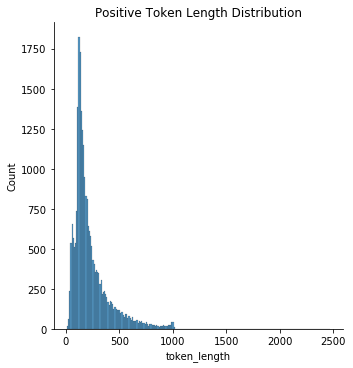

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 360x576 with 0 Axes>

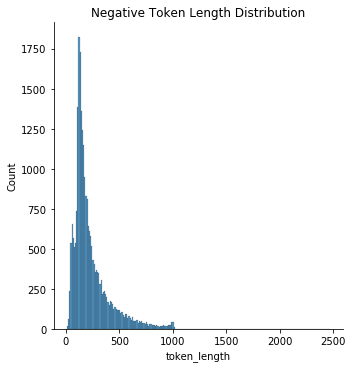

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

In [ ]:
# see most minimum length token
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


## Clean and Preprocess
1. Create text cleaning method pipeline
2. Create text preprocessing method pipeline
3. Save preprocessed data as new csv file

In [ ]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)
    # return re.sub(r"https?://\S+|www\.\S+", "", text)

def rm_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    # return re.sub('', re.compile(r'<[^>]+>'), text)
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces
    # s = re.sub(r'([.,!?()])', r' \1 ', s)
    # s = re.sub(r'\s{2,}', ' ', s)
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [ ]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def postag(text):
    # not implemented yet
    return

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [ ]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 50000/50000 [02:59<00:00, 277.87it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [ ]:
# keep only processed and label columns
data[['processed', 'label']].to_csv('../data/imdb_processed.csv', index=False, header=True)

## Prepare Dataset
1. Build a vocabulary
2. Encode reviews
3. Pad short reviews and trim long reviews
4. Make train test val split
5. Prepare dataloaders and batches

In [3]:
# read processed data
data = pd.read_csv('/content/drive/MyDrive/Advanced NLP/imdb_processed.csv')

for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')    
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

In [4]:
# get all processed reviews
reviews = data.processed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()

# check our list
words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [5]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [7]:
import pickle

pickle.dump(word2int, open('/content/drive/MyDrive/Advanced NLP/w2i_imdb_capitalized.pkl', 'wb'))
pickle.dump(int2word, open('/content/drive/MyDrive/Advanced NLP/i2w_imdb_capitalized.pkl', 'wb'))

In [8]:
# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# print first-10 words of first 5 reviews
for i in range(5):
    print(reviews_enc[i][:5])

100%|██████████| 50000/50000 [00:02<00:00, 20118.73it/s]

[191, 1083, 930, 81, 3724]
[47, 328, 59, 244, 1]
[3, 95, 328, 30, 1041]
[2408, 136, 59, 241, 3230]
[70982, 10566, 1081, 1941, 7538]


In [78]:
# padding sequences

def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  191,  1083,   930,    81,  3724,   186,  3030,     1,   118,
          114],
       [   47,   328,    59,   244,     1,     7,  1267,  1608, 17875,
            4],
       [    3,    95,   328,    30,  1041,    13,   845,  1774,  2633,
            2],
       [ 2408,   136,    59,   241,  3230,    37,   650,  4298,   583,
          882],
       [70982, 10566,  1081,  1941,  7538,  2280,  1313,     6,    46,
            1],
       [ 2795,     4,    13,   368,     5,     2,    17, 42503,     2,
         2952],
       [    3,   197,    18,    10,    21, 12517,  1904, 55922,   121,
         5112],
       [   14,    31,   427,     2,  1342,  4021,   165,    34,  2960,
            1],
       [47893,   980,   359,     6,     3,   180,   776,    81,     6,
            1],
       [   64,    10,   125,  2269,  5606,  1980,    10,     5,     1,
           64]])

In [79]:
# get labels as numpy
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [80]:
# train test split
train_size = .7     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [81]:
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


In [82]:
# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [83]:
# check our batches
dataiter = iter(trainloader)
x, y = dataiter.next()

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[    3,   124,    48,  ...,     0,     0,     0],
        [    3,   200,    34,  ...,     0,     0,     0],
        [  549,     2,     6,  ...,     0,     0,     0],
        ...,
        [   47, 26292,   257,  ...,     0,     0,     0],
        [87517, 41682,     8,  ...,     0,     0,     0],
        [   14,  1614,     1,  ...,     0,     0,     0]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0])


## Modelling
1. Build network architecture
2. Define model hyperparameters
3. Setup training config
4. Write training-validation loop
5. Plot Loss
6. Inference on test set
7. Evaluation metrics

In [84]:
# model architecture

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

In [85]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [89]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [90]:
# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 5
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

In [91]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
            
            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        # epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Advanced NLP/models/sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:   0%|          | 0/5 [03:13<?, ?it/s, Val Loss: 0.692 | Val Acc: 0.516]

Epoch 1/5 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.692 Val Acc: 0.516


Training:  40%|████      | 2/5 [06:28<09:43, 194.43s/it, Training batch 0/274]            

Epoch 2/5 | Train Loss: 0.695 Train Acc: 0.503 | Val Loss: 0.694 Val Acc: 0.500
[WARNING] Validation loss did not improved (0.692 --> 0.694)


Training:  40%|████      | 2/5 [09:43<09:43, 194.43s/it, Val Loss: 0.692 | Val Acc: 0.508]

Epoch 3/5 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.692 Val Acc: 0.508


Training:  60%|██████    | 3/5 [12:58<06:29, 194.86s/it, Val Loss: 0.691 | Val Acc: 0.522]

Epoch 4/5 | Train Loss: 0.685 Train Acc: 0.536 | Val Loss: 0.691 Val Acc: 0.522


Training:  80%|████████  | 4/5 [16:14<03:15, 195.03s/it, Val Loss: 0.463 | Val Acc: 0.810]

Epoch 5/5 | Train Loss: 0.550 Train Acc: 0.723 | Val Loss: 0.463 Val Acc: 0.810


Training: 100%|██████████| 5/5 [16:14<00:00, 194.97s/it, Val Loss: 0.463 | Val Acc: 0.810]


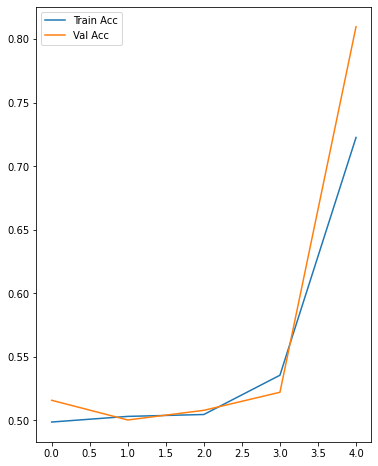

In [92]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

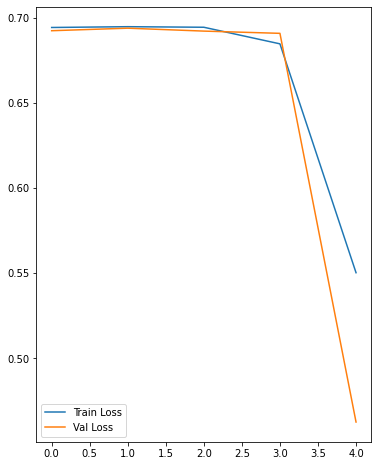

In [93]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()